# Datetime features to capture seasonality

In this notebook we will show how to create features from the calendar (e.g, day of the week, month of the year) to help capture seasonality. This is a prerequisite for creating seasonal dummy features, shown in the next lecture. We will also show how we can use these features to create a forecast. Later in the course, we have a whole section dedicated to extracting features from date and time where we cover this topic in even more depth.

In [1]:
import re
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_context("talk")

# Data set synopsis

We will use the Victoria electricity demand dataset found here: 
https://github.com/tidyverts/tsibbledata/tree/master/data-raw/vic_elec. This dataset is used in the [original MSTL paper [1]](https://arxiv.org/pdf/2107.13462.pdf). It is the total electricity demand at a half hourly granularity for the state of Victora in Australia from 2002 to the start of 2015. A more detailed description of the dataset can be found [here](https://rdrr.io/cran/tsibbledata/man/vic_elec.html). 

We resampled the dataset to hourly in the 4th data preparation notebook in the "01-Create-Datasets" folder in this repo. For instructions on how to download, prepare, and store the dataset, refer to notebook number 4, in the folder "01-Create-Datasets" from this repo.

## References
[1] [K. Bandura, R.J. Hyndman, and C. Bergmeir (2021)
    MSTL: A Seasonal-Trend Decomposition Algorithm for Time Series with Multiple
    Seasonal Patterns. arXiv preprint arXiv:2107.13462.](https://arxiv.org/pdf/2107.13462.pdf)

# Load data

In [2]:
data = pd.read_csv(
    "../Datasets/victoria_electricity_demand.csv",
    usecols=["demand", "date_time"],
    parse_dates=["date_time"],
    index_col=["date_time"],
)

In [3]:
data.shape

(115368, 1)

The data is relatively large compared to the other datasets we have been working with. If the rest of this notebook runs too slowly try filtering to a recent segment of the data. For example by running:

```Python
# Filter to the previous 3 years of the dataset
data = data.loc["2012":]
```

## Plot the data

There time series is high frequency and over a long period. Let's plot the previous three years.

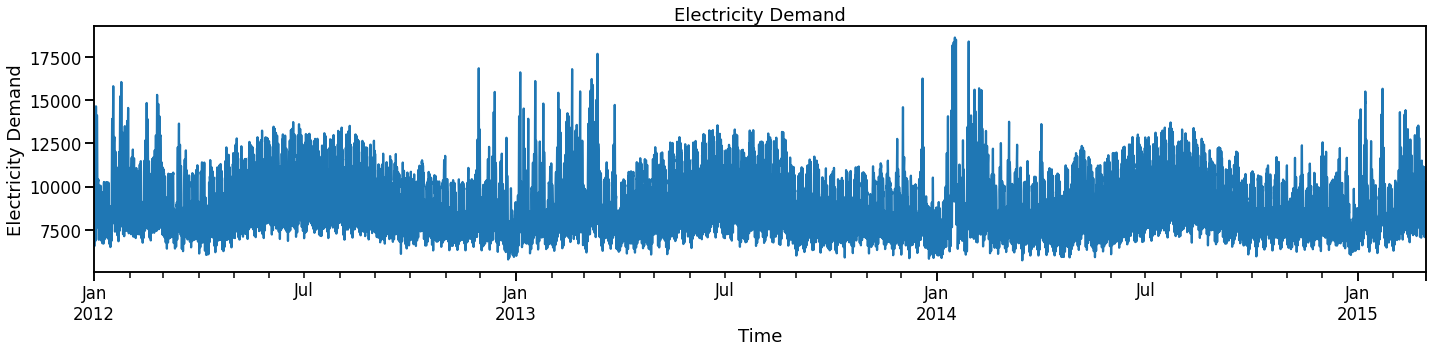

In [4]:
fig, ax = plt.subplots(figsize=[20, 5])
data.loc["2012":].plot(y="demand", legend=None, ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Electricity Demand")
ax.set_title("Electricity Demand")
plt.tight_layout()

# Creating datetime features with sktime

Datetime features are covered in depth in the `Time Features` section of the course. In that section we show how to create these features in `Pandas` and `Feature-engine`. In this section we show how to create these features using the `DateTimeFeatures` transformer in `sktime`.

In [5]:
from sktime.transformations.series.date import DateTimeFeatures

In [6]:
transformer = DateTimeFeatures(ts_freq="H", # Frequency of the time series
                               feature_scope="comprehensive", # Can be "comprehensive", 
                                                              # "efficient", "minimal".
                                                              # Depending on the time series
                                                              # frequency a sensible set is 
                                                              # automatically chosen.
                               keep_original_columns=True, # Flag if we want to keep columns
                                                           # in the dataframe passed to `transform`.
                              )

transformer.fit(data) # This transformer has a fit method which does
                      # not learn any parameters. sktime still  
                      # performs a series of checks when we call `fit` on the time series 
                      # (e.g., is the time series sorted?, are there missing timestamps?).
            
result = transformer.transform(data) # Create the features from the datetime index. 
result.head()

/Users/kishan_manani/.pyenv/versions/3.8.7/envs/udemy-ts/lib/python3.8/site-packages/sktime/transformations/series/date.py:151: FutureWarning: Currently the default value of `keep_original_columns
 is `True`. In future releases this will be changed 
 to `False`. To keep the current behaviour explicitly 
 set `keep_original_columns=True`.
  warnings.warn(
/Users/kishan_manani/.pyenv/versions/3.8.7/envs/udemy-ts/lib/python3.8/site-packages/sktime/transformations/series/date.py:151: FutureWarning: Currently the default value of `keep_original_columns
 is `True`. In future releases this will be changed 
 to `False`. To keep the current behaviour explicitly 
 set `keep_original_columns=True`.
  warnings.warn(


,demand,year,quarter_of_year,month_of_year,week_of_year,day_of_year,month_of_quarter,week_of_quarter,day_of_quarter,week_of_month,day_of_month,day_of_week,hour_of_day,is_weekend
date_time,,,,,,,,,,,,,,
2002-01-01 00:00:00,6919.366092,2002,1,1,1,1,1,2,1,1,1,1,0,0
2002-01-01 01:00:00,7165.974188,2002,1,1,1,1,1,2,1,1,1,1,1,0
2002-01-01 02:00:00,6406.542994,2002,1,1,1,1,1,2,1,1,1,1,2,0
2002-01-01 03:00:00,5815.537828,2002,1,1,1,1,1,2,1,1,1,1,3,0
2002-01-01 04:00:00,5497.732922,2002,1,1,1,1,1,2,1,1,1,1,4,0


We can also manually select the date time features we want to create using the `manual_selection` argument. 

The valid set of values for `manual_selection` for the most recent version of sktime during the creation of this notebook (i.e., version 0.15.1) is:
- year 
- quarter_of_year 
- month_of_year 
- week_of_year 
- day_of_year 
- month_of_quarter 
- week_of_quarter 
- day_of_quarter 
- week_of_month 
- day_of_month 
- day_of_week 
- hour_of_day 
- minute_of_hour 
- second_of_minute 
- millisecond_of_second 
- is_weekend

In [7]:
# Specify which datetime features to create
datetime_features = [
                       "year",
                       "month_of_year",
                       "week_of_year",
                       "day_of_year",
                       "day_of_week",
                       "hour_of_day",
                       "is_weekend",
                    ]

# Create the DateTimeFeatures transformer
transformer = DateTimeFeatures( # We do not need to specify the frequency of the time series
                                # if we are manually selecting which features to create.
                               manual_selection=datetime_features, # Select which features to
                                                                   # create.
                               keep_original_columns=True, # Flag if we want to keep columns
                                                            # in dataframe passed to `transform`.
                              )

# Fit and transform to create our features
result = transformer.fit_transform(data)
result.head()

/Users/kishan_manani/.pyenv/versions/3.8.7/envs/udemy-ts/lib/python3.8/site-packages/sktime/transformations/series/date.py:151: FutureWarning: Currently the default value of `keep_original_columns
 is `True`. In future releases this will be changed 
 to `False`. To keep the current behaviour explicitly 
 set `keep_original_columns=True`.
  warnings.warn(
/Users/kishan_manani/.pyenv/versions/3.8.7/envs/udemy-ts/lib/python3.8/site-packages/sktime/transformations/series/date.py:151: FutureWarning: Currently the default value of `keep_original_columns
 is `True`. In future releases this will be changed 
 to `False`. To keep the current behaviour explicitly 
 set `keep_original_columns=True`.
  warnings.warn(


,demand,year,month_of_year,week_of_year,day_of_year,day_of_week,hour_of_day,is_weekend
date_time,,,,,,,,
2002-01-01 00:00:00,6919.366092,2002,1,1,1,1,0,0
2002-01-01 01:00:00,7165.974188,2002,1,1,1,1,1,0
2002-01-01 02:00:00,6406.542994,2002,1,1,1,1,2,0
2002-01-01 03:00:00,5815.537828,2002,1,1,1,1,3,0
2002-01-01 04:00:00,5497.732922,2002,1,1,1,1,4,0


# Plots to understand seasonality

Let's quickly look at the average by different periods (daily, weekly, yearly, etc.) to remind ourselves of the seasonality. There isn't much trend in this data so we won't be too concerned about not de-trending the data first.

For a full exploratory data analysis of seasonality in this dataset see notebook `06-MSTL-decomposition.ipynb` in the `04-Time-Series-Decomposition` section of this repo. 

<AxesSubplot: xlabel='hour_of_day', ylabel='demand'>

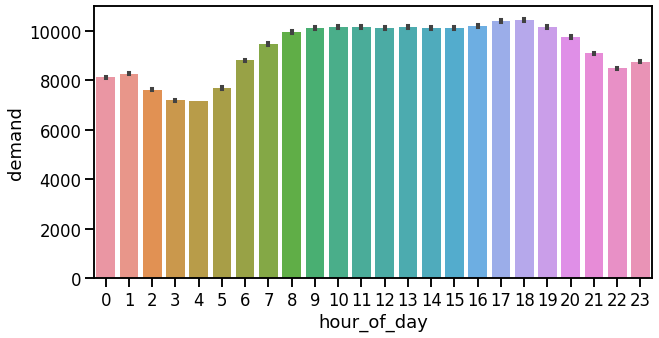

In [8]:
# Plot average demand by hour of day
# to understand daily seasonality. 
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data=result, y="demand", x="hour_of_day", ax=ax)

<AxesSubplot: xlabel='day_of_week', ylabel='demand'>

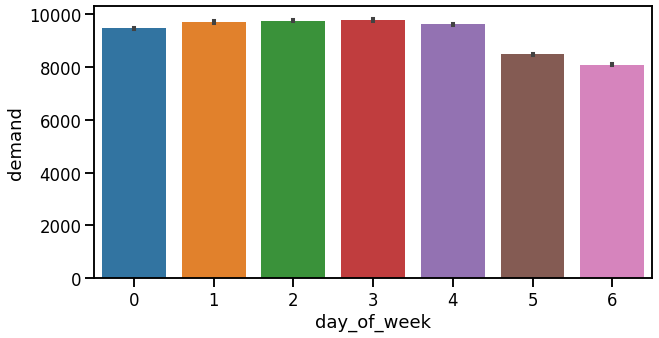

In [9]:
# Plot average demand by day of week
# to understand weekly seasonality. 
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data=result, y="demand", x="day_of_week", ax=ax)

<AxesSubplot: xlabel='month_of_year', ylabel='demand'>

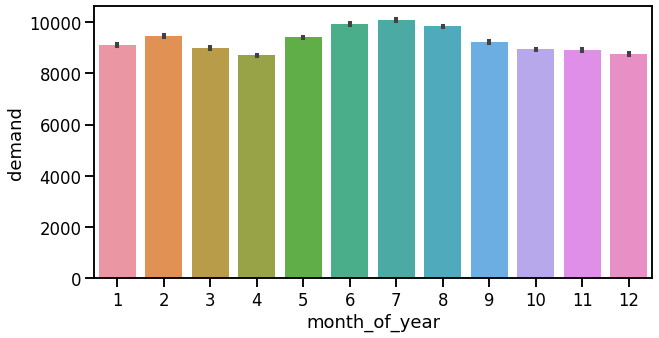

In [10]:
# Plot average demand by month of year
# to understand yearly seasonality. 
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data=result, y="demand", x="month_of_year", ax=ax)

# Let's build some forecasts!

Let's build a recursive forecast and see how we can include datetime features in our feature engineering pipeline.

In [11]:
# Date time features to capture seasonality
from sktime.transformations.series.date import DateTimeFeatures

# --- The transformers from earlier in the course. --- #
# Lag and window features
from sktime.transformations.series.summarize import WindowSummarizer
# Time features for trend 
from sktime.transformations.series.time_since import TimeSince
from sklearn.preprocessing import PolynomialFeatures
# Rescaling transformer for linear models with regularisation
from sklearn.preprocessing import MinMaxScaler
# Pipelines to create feature engineering pipeline
from sklearn.pipeline import make_pipeline, make_union
# Used to reset sklearn estimators
from sklearn.base import clone

# Let's ensure all sklearn transformers output pandas dataframes
from sklearn import set_config
set_config(transform_output="pandas")  # Upgrade to scikit-learn >= 0.12
                                       # for this feature

In [12]:
df = data.copy()
df.head()

,demand
date_time,
2002-01-01 00:00:00,6919.366092
2002-01-01 01:00:00,7165.974188
2002-01-01 02:00:00,6406.542994
2002-01-01 03:00:00,5815.537828
2002-01-01 04:00:00,5497.732922


Specify target name.

In [13]:
target=["demand"] # Note: it's in a list.
                  # This ensures we'll get
                  # a dataframe when using df.loc[:, target]
                  # rather than a pandas Series. 
                  # This can also be useful if we have
                  # multiple targets.

Prepare our transformers.

In [14]:
# Polynomial time features for trend
time_feats = make_pipeline(
                           TimeSince(), 
                           PolynomialFeatures(degree=1, include_bias=False)
                          )

# Datetime features
# Specify which datetime features to create
datetime_features = [
                       "year",
                       "month_of_year",
                       "week_of_year",
                       "day_of_year",
                       "day_of_week",
                       "hour_of_day",
                       "is_weekend",
                    ]

datetime_feats = DateTimeFeatures(
                               manual_selection=datetime_features, 
                               keep_original_columns=False, 
                              )



# Compute lag and window features.
lag_window_feats = WindowSummarizer(
    lag_feature={
        "lag": np.arange(1, 25),  # Lag features.
        "mean": [[1, 24], [1, 24*7]],  # [[lag, window size]]
    },
    target_cols=target,
    truncate="bfill",  # Backfill missing values from lagging and windowing.
)

/Users/kishan_manani/.pyenv/versions/3.8.7/envs/udemy-ts/lib/python3.8/site-packages/sktime/transformations/series/date.py:151: FutureWarning: Currently the default value of `keep_original_columns
 is `True`. In future releases this will be changed 
 to `False`. To keep the current behaviour explicitly 
 set `keep_original_columns=True`.
  warnings.warn(


Create a pipeline to create all our features.

In [15]:
# To see how the datetime features help
# try commenting them out and just using
# lag features, then try just using datetime
# features.
pipeline = make_union(
    datetime_feats,
    time_feats, 
    lag_window_feats,
)

# Apply min-max scaling to all the features
pipeline = make_pipeline(pipeline, MinMaxScaler())

In [16]:
pipeline

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('datetimefeatures',
                                                 DateTimeFeatures(keep_original_columns=False,
                                                                  manual_selection=['year',
                                                                                    'month_of_year',
                                                                                    'week_of_year',
                                                                                    'day_of_year',
                                                                                    'day_of_week',
                                                                                    'hour_of_day',
                                                                                    'is_weekend'])),
                                                ('pipeline',
                                                 Pipeline(steps=[('timesince',
                                                                  TimeSince()),
                                                                 ('polynomialfeatures',
                                                                  PolynomialFeatures(degree=1,
                                                                                     include_bias=False))])),
                                                ('windowsummarizer',
                                                 WindowSummarizer(lag_feature={'lag': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24]),
                                                                               'mean': [[1,
                                                                                         24],
                                                                                        [1,
                                                                                         168]]},
                                                                  target_cols=['demand'],
                                                                  truncate='bfill'))])),
                ('minmaxscaler', MinMaxScaler())])

Let's check how our feature engineering pipeline behaves.

In [17]:
pipeline.fit_transform(df.head())

/Users/kishan_manani/.pyenv/versions/3.8.7/envs/udemy-ts/lib/python3.8/site-packages/sktime/transformations/series/date.py:151: FutureWarning: Currently the default value of `keep_original_columns
 is `True`. In future releases this will be changed 
 to `False`. To keep the current behaviour explicitly 
 set `keep_original_columns=True`.
  warnings.warn(
/Users/kishan_manani/.pyenv/versions/3.8.7/envs/udemy-ts/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/Users/kishan_manani/.pyenv/versions/3.8.7/envs/udemy-ts/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


,year,month_of_year,week_of_year,day_of_year,day_of_week,hour_of_day,is_weekend,time_since_2002-01-01 00:00:00,demand_lag_1,demand_lag_15,...,demand_lag_23,demand_lag_3,demand_lag_22,demand_lag_4,demand_lag_6,demand_lag_21,demand_lag_5,demand_lag_16,demand_mean_1_168,demand_mean_1_24
date_time,,,,,,,,,,,,,,,,,,,,,
2002-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.817386,NaN,...,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.25,0.817386,NaN,...,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.50,0.0,0.50,1.000000,NaN,...,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.75,0.437640,NaN,...,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,1.00,0.0,1.00,0.000000,NaN,...,NaN,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Let's reset our feature engineering pipeline.

In [18]:
# We can use `clone` to return an unfitted version
# of the pipeline.
pipeline = clone(pipeline)

/Users/kishan_manani/.pyenv/versions/3.8.7/envs/udemy-ts/lib/python3.8/site-packages/sktime/transformations/series/date.py:151: FutureWarning: Currently the default value of `keep_original_columns
 is `True`. In future releases this will be changed 
 to `False`. To keep the current behaviour explicitly 
 set `keep_original_columns=True`.
  warnings.warn(


Let's build a recursive forecast.

We'll start with configuring the model, the forecast start time, the number of steps to forecast, and the forecasting horizon, and the model.

In [19]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

In [20]:
# --- CONFIG --- #
# Define time of first forecast, this determines our train / test split.                                              
forecast_start_time = df.index.max() - pd.DateOffset(weeks=2) # Start two weeks from the end.

# Define number of steps to forecast.
num_of_forecast_steps = 24*14 # 2 weeks, this is a lot!

# Define the model.
model = LGBMRegressor(
                      boosting = "gbdt",
                      learning_rate=0.1,
                      n_estimators=100,
                      n_jobs=-1, # Use all cores
                     )

# Create a list of periods that we'll forecast over.
forecast_horizon = pd.date_range(forecast_start_time, 
                                   periods=num_of_forecast_steps,
                                   freq="H")

# How much data in the past is needed to create our features
look_back_window_size = pd.DateOffset(weeks=1) # We need the latest 24*7 time periods
                                             # in our predict dataframe to build our 
                                             # window features.

Let's create our training dataframe.

In [21]:
# --- CREATE TRAINING & TESTING DATAFRAME  --- #
# Ensure we only have training data up to the start
# of the forecast.
df_train = df.loc[df.index < forecast_start_time].copy()
df_test = df.loc[df.index >= forecast_start_time].copy()

Let's prepare the dataframe that we will pass to `model.predict()`. This will contain some portion of time series during the training period so we can create any features that require historic data.

In [22]:
# --- FEATURE ENGINEERING--- #
# Create X_train and y_train
y_train = df_train[target]
X_train = pipeline.fit_transform(df_train)

# LightGBM cannot handle column names which have
# certain characters (e.g., ":"). We replace these
# with `_`. 
if "lightgbm" in model.__module__: # checks if model is from lightgbm
    X_train = X_train.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "_", x))


# --- MODEL TRAINING---#
# Train one-step ahead forecast model
model.fit(X_train, y_train)

/Users/kishan_manani/.pyenv/versions/3.8.7/envs/udemy-ts/lib/python3.8/site-packages/sktime/transformations/series/date.py:151: FutureWarning: Currently the default value of `keep_original_columns
 is `True`. In future releases this will be changed 
 to `False`. To keep the current behaviour explicitly 
 set `keep_original_columns=True`.
  warnings.warn(


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


LGBMRegressor(boosting='gbdt')

In [23]:
# --- CREATE DYNAMIC PREDICTION DATAFRAME  --- #
# We will recursively append our forecasts to this 
# dataframe and re-compute our lag and window features from the
# target in this dataframe. It contains data in both the training period 
# and forecast period which is needed for some transformers (e.g., lags and windows).
look_back_start_time = forecast_start_time - look_back_window_size

# Create `df_predict` which has data going as far back
# as needed to create features which need past values.
df_predict = df_train.loc[look_back_start_time:].copy()

# Extend index into forecast horizon
df_predict = pd.concat([
                  df_predict,
                  pd.DataFrame(index=forecast_horizon)
                 ])

Let's compute our `X_train` and `y_train` and fit our model!

Let's recursively create `X_test` and make our predictions and append them to the `df_predict` dataframe.

In [24]:
# --- RECURSIVE FORECASTING LOOP --- #
for forecast_time in forecast_horizon:    
    # Compute features during the forecast horizon
    X_test = pipeline.transform(df_predict)
    X_test = X_test.loc[[forecast_time]] 

    # Predict one step ahead. 
    y_pred = model.predict(X_test)
    
    # Append forecast to the target variable columnn in our
    # dynamic forecast dataframe `df_predict`. This `df_predict`
    # is ready for the next iteration where we will re-compute
    # features derived from the target such as lags and windows.
    df_predict.loc[[forecast_time], target] = y_pred

Let's retrieve our forecast and actuals during the forest horizon.

In [25]:
# --- GET FORECAST AND TEST VALUES --- #    
y_forecast = df_predict.loc[forecast_horizon, target]
y_test = df_test.loc[forecast_start_time:, target]

Let's create predictions on the training set using our one step ahead forecast model. This is useful to plot when debugging models.

In [26]:
# --- CREATE IN-SAMPLE PREDICTIONS--- #
y_forecast_train = model.predict(X_train)
y_forecast_train = pd.DataFrame(y_forecast_train, index=X_train.index, columns=target)

Let's plot the forecast!

Text(0.5, 1.0, "Forecast with LGBMRegressor(boosting='gbdt')")

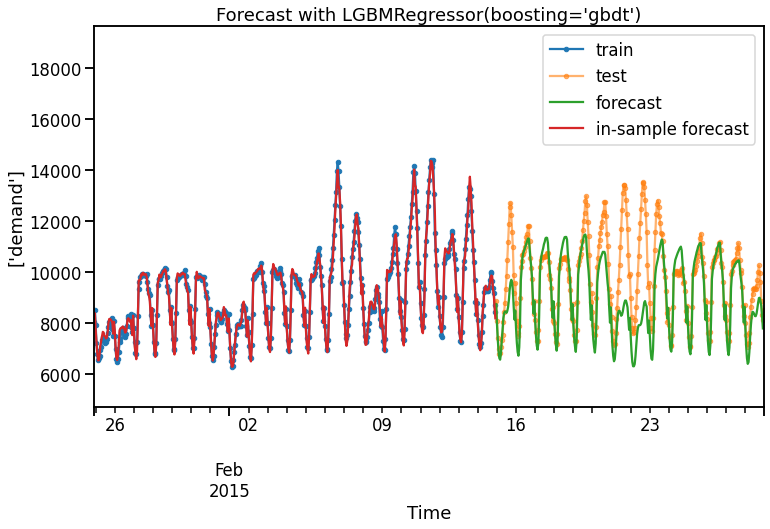

In [27]:
# --- PLOTTING --- #
# Plot the forecast.
fig, ax = plt.subplots(figsize=[12, 7])

# Plot training set.
y_train.plot(ax=ax, marker='.')
# Plot actuals in forecasting horizon.
y_test.plot(ax=ax, marker='.', alpha=0.6)
# Plot forecast.
y_forecast.plot(ax=ax)
# Plot 1 step forecasts in training data.
y_forecast_train.plot(ax=ax)

ax.legend(["train", "test", "forecast", "in-sample forecast"])
ax.set_xlim(xmin=y_train.index.max() - pd.DateOffset(weeks=3))
ax.set_xlabel("Time")
ax.set_ylabel(f"{target}")
ax.set_title(f"Forecast with {model}")

Let's compute the RMSE of this forecast.

In [28]:
# Compute error metrics.
from sklearn.metrics import mean_squared_error
mean_squared_error(y_true=y_test.loc[y_forecast.index],
                   y_pred=y_forecast,
                   squared=False)

1325.5268218150966

Feel free to change the dates, try different models, and different features!

In this notebook we have shown: 1) how to create features from date and time to help capture seasonality, 2) how to add these features to a forecasting pipeline.